# Setup

In [1]:
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import rrule
import datetime as dt

# Pre-analysis

## Import data

In [63]:
# Read csv-file
df = pd.read_csv("Data_Boliga_20220208_cleaned.csv")

n_rows, n_cols = df.shape
print('Number of rows: {}'.format(n_rows))
print('Number of columns: {}'.format(n_cols))

Number of rows: 54793
Number of columns: 13


Check first rows and data types

In [64]:
df.head()

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5000000,2022-01-17,Alm. Salg,93,53763,3,2007,-5,2100,København Ø
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8495000,2022-01-14,Alm. Salg,170,49971,6,1929,0,2100,København Ø
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5400000,2022-01-14,Alm. Salg,105,51429,3,1863,-2,2200,København N
3,E,"Badensgade 48, 2",2300 København S,7200000,2022-01-14,Alm. Salg,65,110769,3,1899,0,2300,København S
4,E,"Badensgade 48, 1",2300 København S,7200000,2022-01-14,Alm. Salg,79,91139,3,1899,0,2300,København S


In [65]:
df.dtypes

Type             object
StreetAddress    object
Area             object
Price             int64
Date             object
SellType         object
Size              int64
Price_m2          int64
Rooms             int64
YearBuilt         int64
PriceChange       int64
PostalCode        int64
AreaName         object
dtype: object

Check number of house types and how it was sold
<br>
<br>
E - apartment
<br>
R - terrace house
<br>
V - villa
<br>
<br>
Alm. Salg - sold on the open market
<br>
Andet - other
<br>
Auktion - auction
<br>
Fam. Salg - sold within family

In [4]:
# Check number of house types sold
print(df.groupby('Type').size())

print(df.groupby('SellType').size())


Type
E    47475
R     3099
V     4219
dtype: int64
SellType
Alm. Salg    47410
Andet         2040
Auktion         49
Fam. Salg     5294
dtype: int64


### Filter data
The main interest is apartments, hence filter out observations which are villas or terrace houses. I also filter out sales that has not been on the open market, since sales within families or auctions might distort the data.

In [66]:
mask = ((df['Type'] == 'E') & (df['SellType'] == 'Alm. Salg'))
df = df[mask].copy()

print(df.shape)

(40673, 13)


Inspect the data with some initial analysis of summary statistics and histograms. Comment about postal code
<br>
<br>
The summary statistics and histograms reveal that there probably are some outliers/bad observations in the data, e.g. the biggest apartment that has been sold is 857 m2, the maximum number of rooms is 13 and the oldest house is built at Year 0. 

In [19]:
df.describe()

,Price,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode
count,4.067300e+04,40673.000000,4.067300e+04,40673.000000,40673.000000,40673.000000,40673.000000
mean,6.110597e+06,84.081528,8.375171e+04,2.828879,1909.852212,-1.215696,2201.134463
std,8.870159e+06,36.692984,1.798071e+05,1.142108,247.538151,4.237192,379.485450
min,5.119900e+04,12.000000,4.570000e+02,1.000000,0.000000,-99.000000,1050.000000
25%,2.225000e+06,58.000000,3.423900e+04,2.000000,1904.000000,-2.000000,2100.000000
50%,3.400000e+06,76.000000,4.210500e+04,3.000000,1935.000000,0.000000,2300.000000
75%,5.275000e+06,102.000000,5.253600e+04,3.000000,1975.000000,0.000000,2450.000000
max,8.500000e+07,857.000000,4.083333e+06,13.000000,2021.000000,249.000000,2900.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Price_m2'}>],
       [<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'PriceChange'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

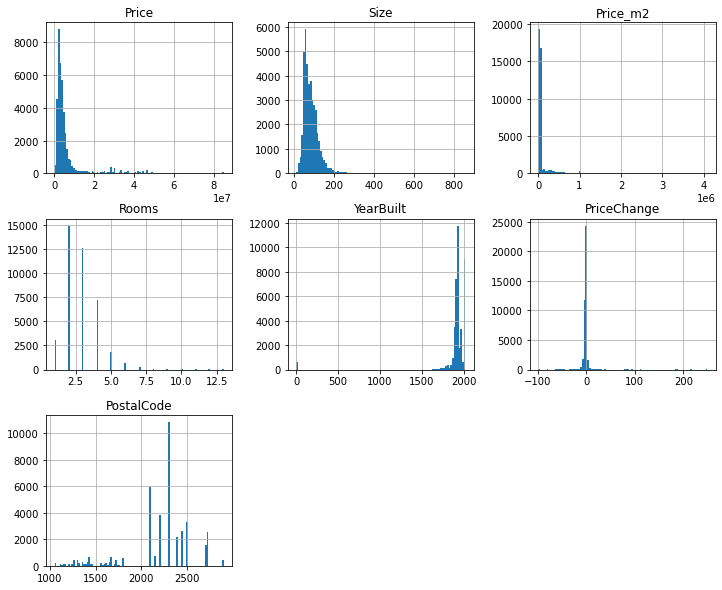

In [20]:
df.hist(bins=100, figsize=(12,10))

### Transform price
Dealing with prices from different years, there is a need to adjust these to the inflation. I collected Danish inflation data from Statistics Denmar (link).

In [59]:
df_inf = pd.read_csv("DST_Inflation_2015_2022.csv", header = None)

df_inf.head()

,0,1,2
0,,2015M01,98.9
1,,2015M02,99.7
2,,2015M03,100.2
3,,2015M04,100.4
4,,2015M05,100.4


Name the columns of the data frame and split the column, (1), containing year and month into two, so that it can be joined to the data frame with observations.

In [60]:
df_inf.drop(0, axis = 1, inplace = True)

df_inf.columns = ['YearMonth','Index']

df_inf[['Year', 'Month']] = df_inf['YearMonth'].str.split('M', expand = True).astype(int)

df_inf.drop('YearMonth', axis = 1, inplace = True)

df_inf.head()

,Index,Year,Month
0,98.9,2015,1
1,99.7,2015,2
2,100.2,2015,3
3,100.4,2015,4
4,100.4,2015,5


Join data frame with inflation index to data frame with prices and calculate adjusted the prices.

In [68]:
# Make date column into date format
df['Date'] = pd.to_datetime(df['Date'])

df['Date_Year']  = df['Date'].dt.year
df['Date_Month'] = df['Date'].dt.month
df['Date_Week'] = df['Date'].dt.week


C:\Users\marti\AppData\Local\Temp/ipykernel_17872/1270182985.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Date_Week'] = df['Date'].dt.week


In [69]:
# Join data frames
df = df.merge(df_inf,
         how = 'left',
         left_on = ['Date_Year','Date_Month'],
         right_on = ['Year', 'Month']
        )

# Calculate adjusted prices
df['Price_idx'] = df['Price'] * df['Index']/100
df['Prce_m2_idx'] = df['Price_m2'] * df['Index']/100

df.head()


,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,...,PostalCode,AreaName,Date_Year,Date_Month,Date_Week,Index,Year,Month,Price_idx,Prce_m2_idx
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5000000,2022-01-17,Alm. Salg,93,53763,3,2007,...,2100,København Ø,2022,1,3,108.0,2022.0,1.0,5400000.0,58064.04
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8495000,2022-01-14,Alm. Salg,170,49971,6,1929,...,2100,København Ø,2022,1,2,108.0,2022.0,1.0,9174600.0,53968.68
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5400000,2022-01-14,Alm. Salg,105,51429,3,1863,...,2200,København N,2022,1,2,108.0,2022.0,1.0,5832000.0,55543.32
3,E,"Badensgade 48, 2",2300 København S,7200000,2022-01-14,Alm. Salg,65,110769,3,1899,...,2300,København S,2022,1,2,108.0,2022.0,1.0,7776000.0,119630.52
4,E,"Badensgade 48, 1",2300 København S,7200000,2022-01-14,Alm. Salg,79,91139,3,1899,...,2300,København S,2022,1,2,108.0,2022.0,1.0,7776000.0,98430.12



Transform columns to proper data types.
<br>
Date - dates
<br> 
Rooms - discrete
<br>
Postal code - discrete


Check summary statistics divided by number of rooms

In [22]:
df[['Rooms', 'Price', 'Size']].groupby('Rooms').describe()

Price                                                       \
         count          mean           std         min          25%   
Rooms                                                                 
1       3091.0  8.588822e+06  1.518701e+07    190000.0   1350000.00   
2      14961.0  4.092694e+06  7.123536e+06     51199.0   1840000.00   
3      12647.0  5.928003e+06  7.653487e+06    130096.0   2939500.00   
4       7210.0  8.047023e+06  9.113583e+06     58000.0   3895000.00   
5       1796.0  9.398056e+06  8.931185e+06    345000.0   4750000.00   
6        639.0  1.097648e+07  1.039314e+07    666553.0   5137500.00   
7        234.0  1.111328e+07  8.477948e+06    250000.0   6700000.00   
8         65.0  1.230115e+07  8.261265e+06    105000.0   7100000.00   
9         16.0  1.229761e+07  8.690311e+06   4635000.0   8205037.75   
10         8.0  1.775625e+07  7.123675e+06   9250000.0  13350000.00   
11         4.0  2.125000e+07  2.500000e+06  20000000.0  20000000.00   
12         1.0  1.070000e+07           NaN  10700000.0  10700000.00   
13         1.0  3.950000e+07           NaN  39500000.0  39500000.00   

                                              Size                          \
              50%         75%         max    count        mean         std   
Rooms                                                                        
1       1950000.0   8350000.0  85000000.0   3091.0   44.976707   18.882247   
2       2295000.0   2995000.0  85000000.0  14961.0   61.022325   14.141834   
3       3800000.0   5000000.0  49726800.0  12647.0   88.750929   20.913454   
4       4995000.0   6795000.0  49726800.0   7210.0  111.662136   24.805631   
5       6200000.0   8975000.0  49000000.0   1796.0  142.737751   36.759775   
6       7595000.0  10500000.0  49000000.0    639.0  172.763693   38.065389   
7       8750000.0  11575000.0  49000000.0    234.0  209.564103   49.884568   
8      10400000.0  13995000.0  40400000.0     65.0  244.138462   60.649577   
9      10350000.0  12931250.0  39250000.0     16.0  255.375000  112.090365   
10     17250000.0  20000000.0  32500000.0      8.0  323.875000   54.593138   
11     20000000.0  21250000.0  25000000.0      4.0  332.750000   60.500000   
12     10700000.0  10700000.0  10700000.0      1.0  284.000000         NaN   
13     39500000.0  39500000.0  39500000.0      1.0  401.000000         NaN   

                                            
         min     25%    50%     75%    max  
Rooms                                       
1       12.0   34.00   42.0   49.00  219.0  
2       15.0   53.00   58.0   65.00  274.0  
3       40.0   74.00   85.0   99.00  297.0  
4       47.0   96.00  108.0  123.00  339.0  
5       62.0  120.00  136.0  156.00  857.0  
6       75.0  148.00  170.0  190.00  357.0  
7       67.0  176.00  219.0  242.75  386.0  
8      105.0  208.00  235.0  267.00  404.0  
9      134.0  202.75  249.5  270.25  616.0  
10     220.0  302.50  335.5  357.00  392.0  
11     242.0  332.75  363.0  363.00  363.0  
12     284.0  284.00  284.0  284.00  284.0  
13     401.0  401.00  401.0  401.00  401.0

In [23]:
# Discretize number of rooms
df['Rooms_bin'] = pd.cut(df['Rooms'],
                         bins = [0,1,2,3,4,13],
                         labels = ['1','2','3','4','5+'],
                         include_lowest = True
                        )

df['Age'] = 2022 - df['YearBuilt']

# 

print(df.dtypes)
df.describe()

Type                     object
StreetAddress            object
Area                     object
Price                     int64
Date             datetime64[ns]
SellType                 object
Size                      int64
Price_m2                  int64
Rooms                     int64
YearBuilt                 int64
PriceChange               int64
PostalCode                int64
AreaName                 object
Rooms_bin              category
Age                       int64
Date_Year                 int64
Date_Month                int64
Date_Week                 int64
dtype: object


,Price,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,Age,Date_Year,Date_Month,Date_Week
count,4.067300e+04,40673.000000,4.067300e+04,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000,40673.000000
mean,6.110597e+06,84.081528,8.375171e+04,2.828879,1909.852212,-1.215696,2201.134463,112.147788,2018.294274,6.371844,26.072776
std,8.870159e+06,36.692984,1.798071e+05,1.142108,247.538151,4.237192,379.485450,247.538151,1.997311,3.375440,14.726964
min,5.119900e+04,12.000000,4.570000e+02,1.000000,0.000000,-99.000000,1050.000000,1.000000,2015.000000,1.000000,1.000000
25%,2.225000e+06,58.000000,3.423900e+04,2.000000,1904.000000,-2.000000,2100.000000,47.000000,2017.000000,3.000000,13.000000
50%,3.400000e+06,76.000000,4.210500e+04,3.000000,1935.000000,0.000000,2300.000000,87.000000,2018.000000,6.000000,26.000000
75%,5.275000e+06,102.000000,5.253600e+04,3.000000,1975.000000,0.000000,2450.000000,118.000000,2020.000000,9.000000,39.000000
max,8.500000e+07,857.000000,4.083333e+06,13.000000,2021.000000,249.000000,2900.000000,2022.000000,2022.000000,12.000000,53.000000


<AxesSubplot:xlabel='Age', ylabel='Count'>

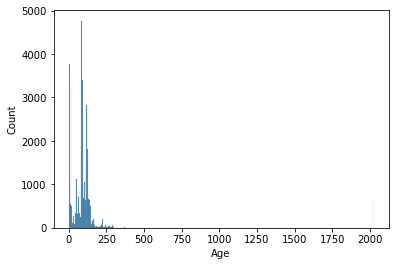

In [24]:
sns.histplot(data = df, x = 'Age')

In [25]:
np.isnan(df['YearBuilt']).sum()


0

In [26]:
df[df['YearBuilt'] == 0]['StreetAddress'].unique()

array(['Monica Zetterlunds Vej 3, 2. 3', 'Drechselsgade 18, 1. 4',
       'Monica Zetterlunds Vej 3, 3. 2',
       'Monica Zetterlunds Vej 17, 3. th',
       'Monica Zetterlunds Vej 13, 1. th',
       'Monica Zetterlunds Vej 3, 3. 3', 'Bjerregårdsvej 12A, 1',
       'Bjerregårdsvej 12', 'Willy Brandts Vej 23, 4. 4',
       'Monica Zetterlunds Vej 15, st. th',
       'Monica Zetterlunds Vej 21, 1. th',
       'Monica Zetterlunds Vej 25, st. tv', 'Willy Brandts Vej 25, 4. 4',
       'Drechselsgade 18, 10. tv', 'Sundkaj 109, st. th',
       'Willy Brandts Vej 25, 5', 'Drechselsgade 18, 5. th',
       'Sundkaj 109, 2. tv', 'Drechselsgade 10C',
       'Drechselsgade 12, 6. tv', 'Monica Zetterlunds Vej 3, 2. 2',
       'Drechselsgade 10D', 'Drechselsgade 12, 10. th',
       'Monica Zetterlunds Vej 9, 1. tv',
       'Monica Zetterlunds Vej 17, 5. th', 'Willy Brandts Vej 25, 3. 3',
       'Monica Zetterlunds Vej 21, st. mf', 'Sundkaj 101, st. th',
       'Monica Zetterlunds Vej 17, 6. th', 'Dr

# Exploratory Analysis


In [28]:


df.head()

C:\Users\marti\AppData\Local\Temp/ipykernel_8628/432349904.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Date_Week'] = df['Date'].dt.week


,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Rooms_bin,Age,Date_Year,Date_Month,Date_Week
0,E,"Amerika Plads 6, 3. th",2100 København Ø,5000000,2022-01-17,Alm. Salg,93,53763,3,2007,-5,2100,København Ø,3,15,2022,1,3
1,E,"Strandvejen 8, 3. tv",2100 København Ø,8495000,2022-01-14,Alm. Salg,170,49971,6,1929,0,2100,København Ø,5+,93,2022,1,2
2,E,"Nørrebrogade 9F, 1. th",2200 København N,5400000,2022-01-14,Alm. Salg,105,51429,3,1863,-2,2200,København N,3,159,2022,1,2
3,E,"Badensgade 48, 2",2300 København S,7200000,2022-01-14,Alm. Salg,65,110769,3,1899,0,2300,København S,3,123,2022,1,2
4,E,"Badensgade 48, 1",2300 København S,7200000,2022-01-14,Alm. Salg,79,91139,3,1899,0,2300,København S,3,123,2022,1,2


<AxesSubplot:xlabel='Date_Year,Date_Week'>

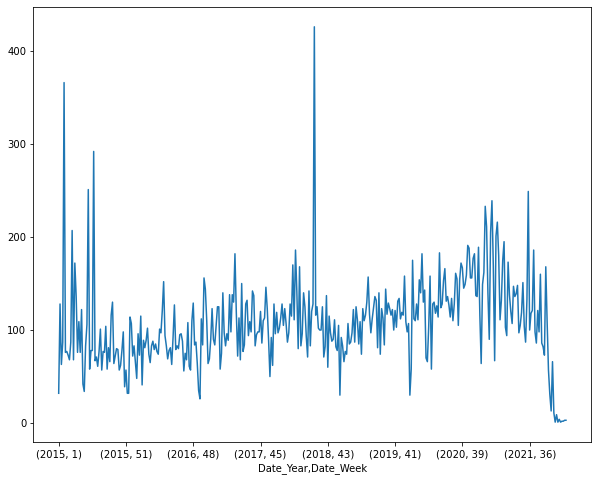

In [29]:
df_yw_c = df.groupby(['Date_Year', 'Date_Week']).size()

df_yw_c.head()

df_yw_c.plot(kind = 'line', figsize = (10, 8))

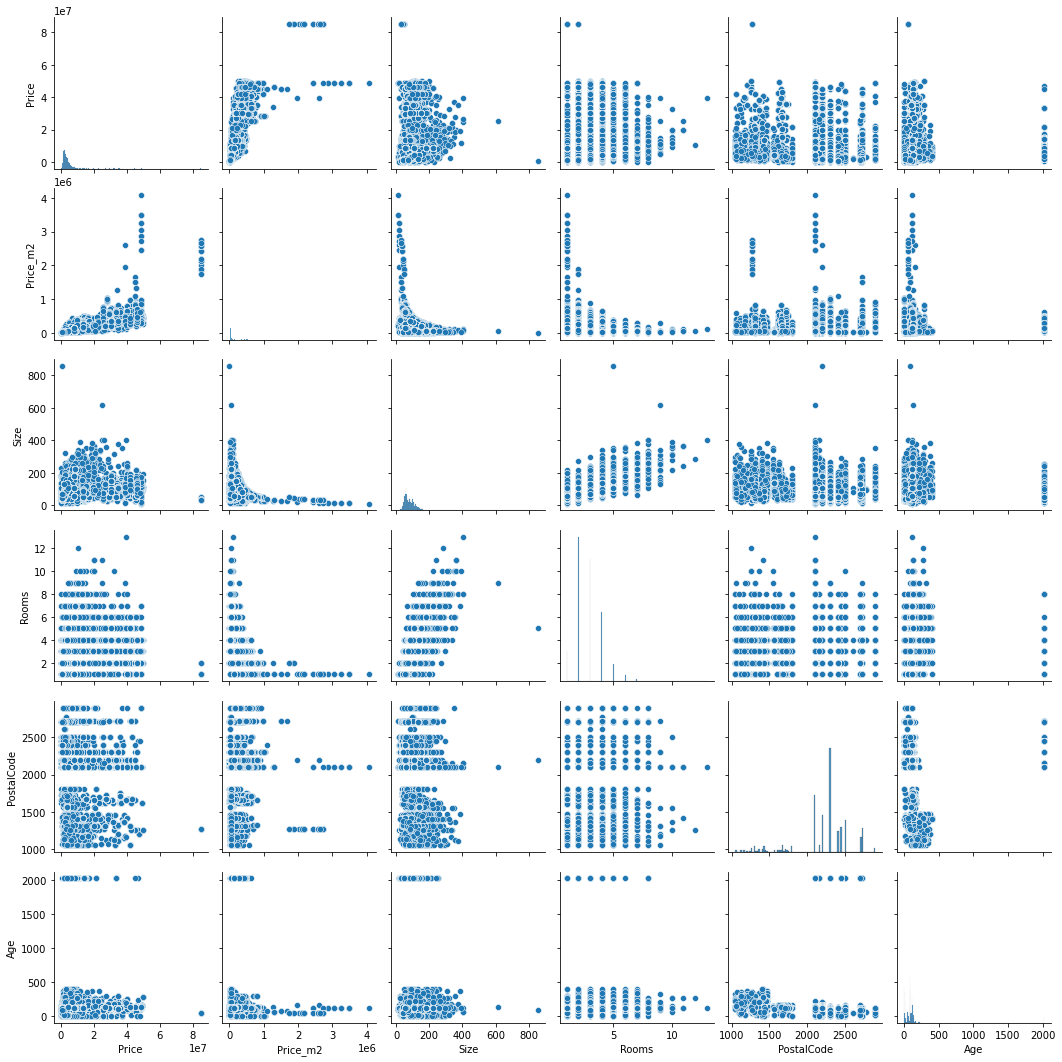

In [30]:
l_cols_pp = ['Price','Price_m2', 'Size', 'Rooms', 'PostalCode', 'Age']

sns.pairplot(df[l_cols_pp])

Check what seems to be outliers

In [31]:
df[(df['Size']> 400) ]

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Rooms_bin,Age,Date_Year,Date_Month,Date_Week
2536,E,"Dag Hammarskjölds Allé 42D, 4",2100 København Ø,25000000,2021-08-19,Alm. Salg,616,40584,9,1886,5,2100,København Ø,5+,136,2021,8,33
3349,E,"Stavangergade 4, 3",2100 København Ø,39500000,2021-06-07,Alm. Salg,401,98504,13,1902,0,2100,København Ø,5+,120,2021,6,23
17339,E,"Rådmandsgade 60, 1",2200 København N,720000,2020-03-18,Alm. Salg,857,840,5,1934,0,2200,København N,5+,88,2020,3,12
47971,E,"Helsinkigade 20, 10",2150 Nordhavn,24900000,2016-01-28,Alm. Salg,404,61634,8,1959,0,2150,Nordhavn,5+,63,2016,1,4
48780,E,"Helsinkigade 20, 12",2150 Nordhavn,26400000,2015-11-24,Alm. Salg,404,65347,8,1959,0,2150,Nordhavn,5+,63,2015,11,48


Filter out outliers

In [32]:
df_filt = df[df['Size'] < 400].copy()

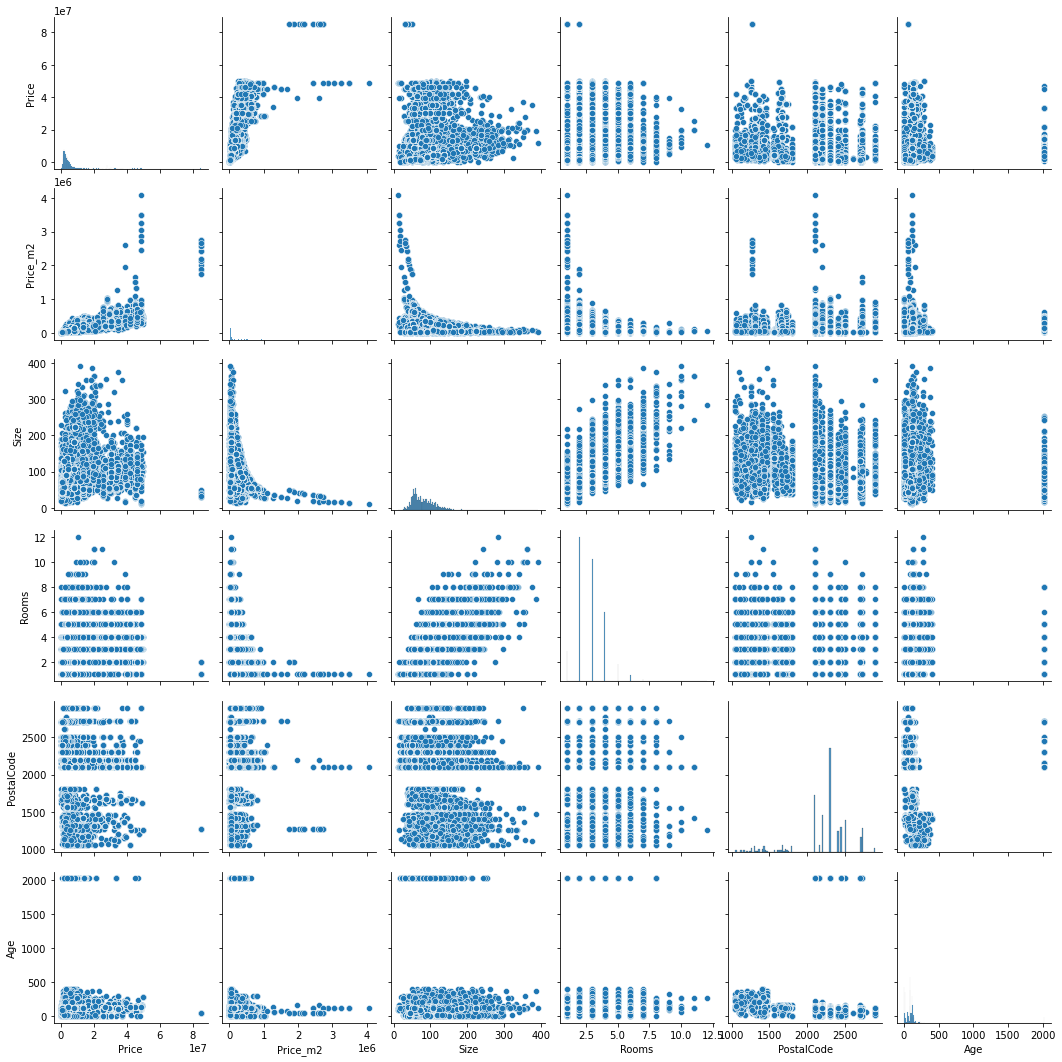

In [33]:
sns.pairplot(df_filt[l_cols_pp])

There still seem to be some outliers with regards to price

In [34]:
df_filt[df_filt['Price'] > 50000000]

,Type,StreetAddress,Area,Price,Date,SellType,Size,Price_m2,Rooms,YearBuilt,PriceChange,PostalCode,AreaName,Rooms_bin,Age,Date_Year,Date_Month,Date_Week
42052,E,"Store Kongensgade 100, 5. 13",1264 København K,85000000,2017-01-16,Alm. Salg,31,2741936,1,1970,0,1264,København K,1,52,2017,1,3
42053,E,"Store Kongensgade 100, 3. 4",1264 København K,85000000,2017-01-16,Alm. Salg,39,2179487,1,1970,0,1264,København K,1,52,2017,1,3
42054,E,"Store Kongensgade 100, 5. 8",1264 København K,85000000,2017-01-16,Alm. Salg,32,2656250,1,1970,0,1264,København K,1,52,2017,1,3
42055,E,"Store Kongensgade 100, 3. 5",1264 København K,85000000,2017-01-16,Alm. Salg,33,2575758,1,1970,0,1264,København K,1,52,2017,1,3
42056,E,"Store Kongensgade 100, 2. 2",1264 København K,85000000,2017-01-16,Alm. Salg,32,2656250,1,1970,0,1264,København K,1,52,2017,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42119,E,"Store Kongensgade 100, 2. 11",1264 København K,85000000,2017-01-16,Alm. Salg,33,2575758,1,1970,0,1264,København K,1,52,2017,1,3
42120,E,"Store Kongensgade 100, 6. 2",1264 København K,85000000,2017-01-16,Alm. Salg,39,2179487,1,1970,0,1264,København K,1,52,2017,1,3
42121,E,"Store Kongensgade 100, 2. 6",1264 København K,85000000,2017-01-16,Alm. Salg,32,2656250,1,1970,0,1264,København K,1,52,2017,1,3
42122,E,"Store Kongensgade 100, 3. 13",1264 København K,85000000,2017-01-16,Alm. Salg,31,2741936,1,1970,0,1264,København K,1,52,2017,1,3


These apartments are all located on the same adress, they are supposedly located in an house. Filter out these obersvations

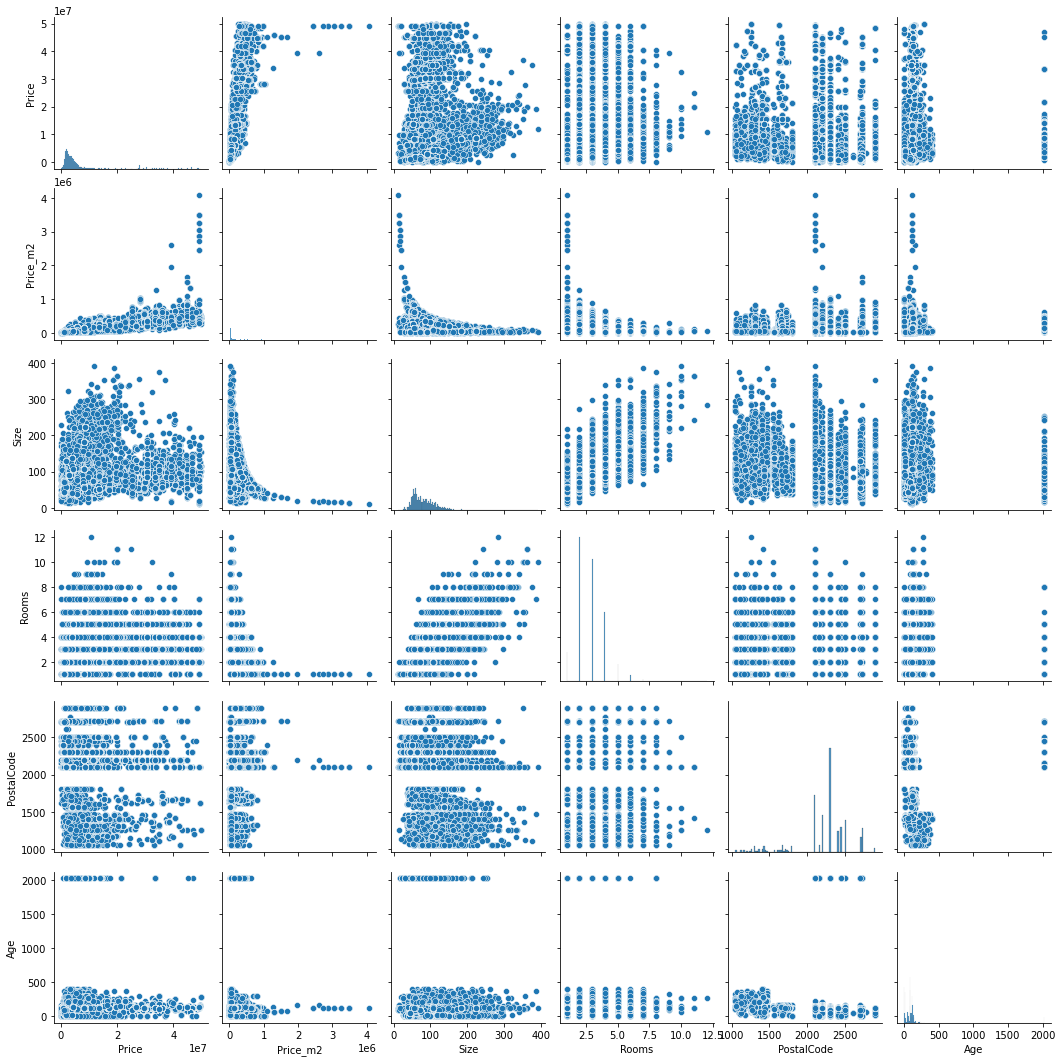

In [35]:
df_filt = df_filt[df_filt['Price'] < 50000000]

sns.pairplot(df_filt[l_cols_pp])

Date_Year  Date_Month
2015       1             35467.0
           2             40093.5
           3             42857.0
           4             34305.0
           5             34459.0
                          ...   
2022       6             31349.0
           7             53042.5
           10            44928.0
           11            45263.0
           12            36818.0
Name: Price_m2, Length: 93, dtype: float64


<AxesSubplot:xlabel='Date_Year,Date_Month'>

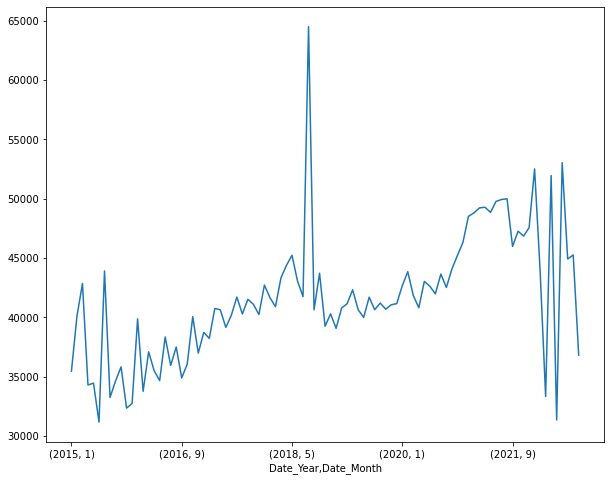

In [60]:
df_yw_AvgP = df_filt.groupby(['Date_Year', 'Date_Month'])['Price_m2'].median()

print(df_yw_AvgP)

df_yw_AvgP.plot(kind = 'line', figsize = (10, 8))

In [49]:
df_ym_AvgP.tail(20)

Date_Year  Date_Week
2021       44           47230.868750
           45           86706.569767
           46           46607.317073
           47           44476.821918
           48           48503.750000
           49           51320.137615
           50           45761.473684
           51           51328.322581
           52           36074.769231
           53           49300.121212
2022       2            57861.272727
           3            53763.000000
           9            45765.666667
           13           33333.000000
           17           52688.750000
           22           31349.000000
           26           53042.500000
           39           44928.000000
           44           37991.333333
           48           37729.666667
Name: Price_m2, dtype: float64

In [ ]:
df_filt[df_filt['Date_Year'] == 2022]['Price_m2'].mean()

48666.72972972973

# Old

<AxesSubplot:xlabel='Date', ylabel='counts'>

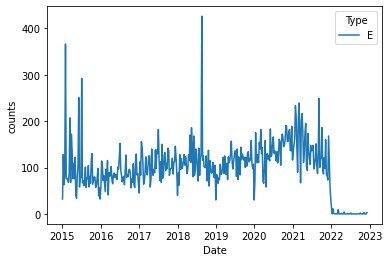

In [11]:
df_tyw_c = df.value_counts(subset = ['Type', 'Date'])

df_tyw_c.head()

df_tyw_c = df_tyw_c.to_frame('counts')
df_tyw_c = df_tyw_c.reset_index()

df_tyw_c = df_tyw_c.set_index('Date')


df_tyw_c = df_tyw_c.groupby(['Type']).resample('w').sum().reset_index()
#df_tyw_c= df_tyw_c.set_index(['Date_Year', 'Date_Week'])


                                               
sns.lineplot(data = df_tyw_c,
             x = 'Date',
             y = 'counts',
             hue = 'Type',
            #figsize = (10, 8)
            )

In [12]:
df_tyw_c.loc[df_tyw_c['Type'] == 'E', 'Type'].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            404, 405, 406, 407, 408, 409, 410, 411, 412, 413],
           dtype='int64', length=414)